### Desafío - Máquinas de Soporte Vectorial

**Nombre alumno:** Julio Valdés

Profesor: Gabriel Tamayo L.

Generación: G5

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

### Descripción
Para esta sesión trabajaremos con la base de datos sobre cáncer mamario de Wisconsin. El objetivo es desarrollar un Clasificador mediante Máquinas de Soporte de Vectores que predizca de forma adecuada en base a una serie de atributos sobre la composición del núcleo de una célula mamaria. Para más detalles técnicos asociados a la base de datos, pueden hacer click en el [link](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.names).

### Ejercicio 1: Preparar el ambiente de trabajo
* Importe todas las librerías a utilizar.
* Excluya las columnas id y Unnamed: 32 de la base de datos.
* Recodifique el vector objetivo diagnosis a numérico para poder procesarlo posteriormente.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')


df = pd.read_csv('breast_cancer.csv').drop(columns = ['id', 'Unnamed: 32'])
label_encoder = LabelEncoder()
df['diagnosis_bin'] = label_encoder.fit_transform(df['diagnosis'])

In [88]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_bin
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


### Ejercicio 2: Visualizando la distribución de los atributos
* Para cada uno de los atributos, grafique los histogramas condicional a cada clase del vector objetivo.
* Agregue las medias correspondientes y reporte a grandes rasgos cuáles son los atributos con una mayor similitud en la distribución.

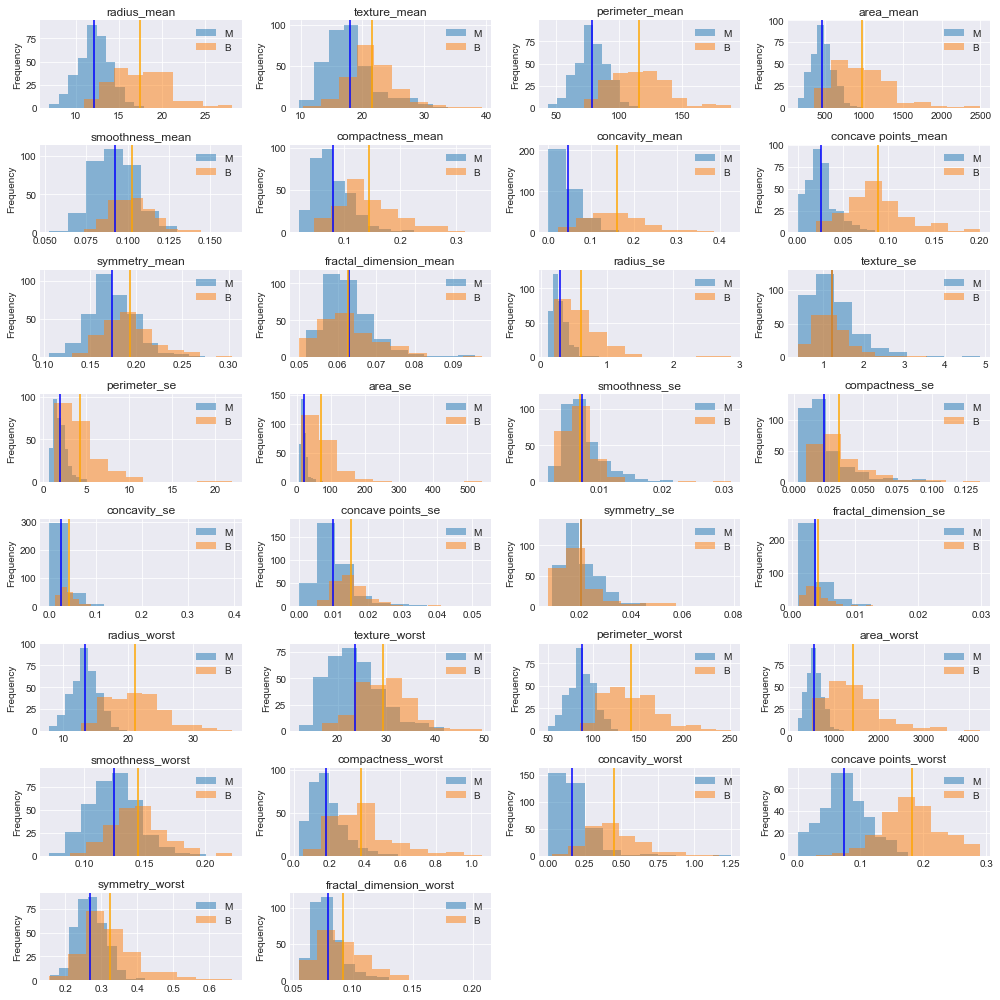

In [89]:
plt.figure(figsize=(14, 14))
rows = 8; cols = 4
for index, column in enumerate(df.drop(['diagnosis', 'diagnosis_bin'], axis=1).columns):
    plt.subplot(rows, cols, index + 1)
    groupby = df.groupby('diagnosis')[column]
    groupby.plot(kind='hist', alpha=.5, title=column)
    plt.legend(df['diagnosis'].unique())
    mean = groupby.mean()
    plt.axvline(mean[0], color='blue')
    plt.axvline(mean[1], color='orange')
plt.tight_layout()

#### Comentarios
* Los atributos con una mayor similitud son: fractal_dimension_mean, texture_se, smoothness_se, symmetry_se, y fractal_dimension_se.

### Ejercicio 3: Estimando el porcentaje de overlap en los atributos
Parte de las virtudes de las Máquinas de Soporte Vectorial es la capacidad de lidiar con clases no separables mediante el proceso de kernelización. Resulta que un aspecto importante que muchas veces se obvía es medir la noseparabilidad de los atributos, condicional a cada clase del vector objetivo.
El procedimiento para estimar el rango de noseparabilidad entre clases se implementa en Python de la siguiente manera:

```python
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_-1"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_-1"]))
    return intersection
```

* La intersección devolverá el porcentaje de comunalidad entre ambas clases, donde mayores niveles indican una mayor comunalidad.
* Utilizando la función, genere un dataframe donde almacenará el nombre del atributo y su porcentaje. Ordene este dataframe de forma descendente y preserve.

In [90]:
def histogram_overlap(df, attribute, target, perc=100):
    # get lower bound
    empirical_lower_bound = np.floor(df[attribute].min())
    # get upper bound
    empirical_upper_bound = np.ceil(df[attribute].max())
    # preserve histograms
    tmp_hist_holder = dict()
    # for each target class
    for unique_value in np.unique(df[target]):
        # get histogram
        tmp, _ = np.histogram(
        # for a specific attribute
        df[df[target] == unique_value][attribute],
        # define percentage
        bins=perc,
        # limit empirical range for comparison
        range=[empirical_lower_bound, empirical_upper_bound]
        )
        # append to dict
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], tmp_hist_holder["h_0"])
    intersection = np.true_divide(np.sum(get_minima),
    np.sum(tmp_hist_holder["h_0"]))
    return intersection

In [91]:
columnas = []
valores = []
for index, column in enumerate(df.drop(['diagnosis', 'diagnosis_bin'], axis=1).columns):
    value = histogram_overlap(df, column, 'diagnosis_bin').round(3)
    columnas.append(column)
    valores.append(value)

comunalidad = pd.DataFrame(valores, index = columnas, columns = ['value']).sort_values(by=['value'], ascending=False)
comunalidad

,value
fractal_dimension_se,0.594
smoothness_se,0.591
fractal_dimension_mean,0.588
symmetry_se,0.569
texture_se,0.549
compactness_se,0.524
smoothness_mean,0.521
symmetry_mean,0.510
concave points_se,0.507
fractal_dimension_worst,0.493


### Ejercicio 4: Selección del modelo por GridSearchCV
* Entrene una serie de modelos SVC con los siguientes hiperparámetros:
    C: [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] .
    gamma: [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10] .
    Validaciones cruzadas: 10.
* Genere un heatmap en base a los puntajes estimados con GridSearchCV .
    * tip: Vea cómo acceder a la llave mean_test_score en el diccionario cv_results_ .
    
#### Digresión: Un par de elementos a considerar en la implementación de GridSearchCV

Si trabajamos con sklearn.model_selection.GridSearchCV , tan solo haciendo la división en dos muestras es suficiente, incorporando los conjuntos X_train y y_train a nuestro objeto instanciado y preservando X_test e y_test como una muestra de validación externa. Si tenemos un archivo de testing externo, se recomienda no hacer división.
    
   * El objeto creado con sklearn.model_selection.GridSearchCV sigue la misma funcionalidad de cualquier método de estimación de scikit-learn , con los pasos de Instanciar y Entrenar. Este objeto tendrá muchos elementos a considerar:
        * sklearn.model_selection.GridSearchCV.cv_results_ devolverá un diccionario donde las llaves representarán distintas métricas y los valores representarán el desempeño de cada modelo:
            * split* Indicará la métrica específica en cada validacieon cruzada y combinación de hiperparámetros.
            * *_time Indicará el tiempo de ejecución en cada modelo.
        * Por lo general trabajaremos con mean_test_score y mean_train_score que representa la media de CV para cada combinación de hiperparámetros.
        * sklearn.model_selection.GridSearchCV.best_estimator_ devuelve un modelo listo para entrenar con la mejor combinación de hiperparámetros.
        * sklearn.model_selection.GridSearchCV.best_score_ devuelve el desempeño promedio del modelo en el testing interno. Si es un problema de clasificación devolverá Accuracy , si es un problema de regresión devolverá MSE.
        
* Reporte en qué rango de cada hiperparámetro el modelo presenta un desempeño eficiente.
* Reporte la mejor combinación de hiperparámetros y el desempeño en la muestra de entrenamiento.

In [106]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, 'radius_mean':'fractal_dimension_worst'], df['diagnosis_bin'], random_state=11238, test_size = 0.33)
c_param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_param_range = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = dict(gamma = gamma_param_range, C = c_param_range)
grid_search_cv = Pipeline([
    ('scaler', StandardScaler()),
    ('grid', GridSearchCV(SVC(), param_grid = param_grid, cv=10))
])
grid_search_cv.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('grid', GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0))])

In [116]:
grid_step = grid_search_cv.named_steps['grid']
print("La mejor combinación de hiperparámetros son %s con un desempeño del %0.2f" % (grid_step.best_params_, grid_step.best_score_))

La mejor combinación de hiperparámetros son {'C': 100, 'gamma': 0.0001} con un desempeño del 0.98


Text(0.5, 1.0, 'Accuracy Heatmap')

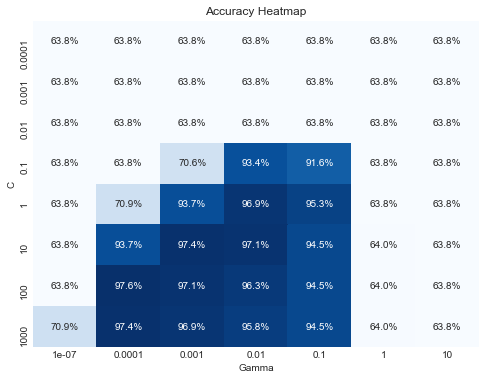

In [117]:
scores = grid_step.cv_results_['mean_test_score'].reshape(len(c_param_range), len(gamma_param_range))
plt.figure(figsize=(8,6))
sns.heatmap(scores,
           xticklabels=gamma_param_range,
           yticklabels=c_param_range,
           annot=True, fmt=".1%",
           cbar=False, cmap='Blues')
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy Heatmap')

#### Al analizar el heatmap anterior, las mejores combinaciones de hiperparámetros se observan con C variando entre 0.1 y 1000 y gamma variando entre 0.0001 y 0.1.

### Ejercicio 5: Validación del modelo en el hold-out sample
* Genere las predicciones del hold-out sample en base a la mejor combinación de hiperparámetros. 
* Genere un reporte con las métricas de desempeño clásicas para los modelos de clasificación. Comente en qué casos el modelo presenta un desempeño deficiente

In [118]:
svc_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=100, gamma=0.0001))
])
svc_rbf.fit(X_train, y_train)
yhat = svc_rbf.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       114
           1       0.99      0.95      0.97        74

   micro avg       0.97      0.97      0.97       188
   macro avg       0.98      0.97      0.97       188
weighted avg       0.97      0.97      0.97       188



#### Al realizar la validación del modelo se observa que el desempeño es bastante bueno para ambas clases, considerando los indicadores de presicion, recall y f1.

### Ejercicio (opcional): Depuración de atributos
* Reentrene el modelo en función de los atributos que presenten un coeficiente de overlap menor a .45.
* Reporte el desempeño del modelo y comente sobre los nuevos hiperparámetros estimados, así como su desempeño en comparación al modelo del ejercicio 5.